# Linear regression - Boston housing prices

1. Title: Boston Housing Data

2. Relevant Information:
   Concerns housing values in suburbs of Boston.

3. Number of Instances: 506

4. Number of Attributes: 13 continuous attributes (including "class" attribute "MEDV"), 1 binary-valued attribute.

5. Attribute Information:
    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per USD 1000  
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks y town
    13. LSTAT    % lower status of the population
    14. MEDV     Median value of owner-occupied homes in USD 1000's
6. Missing Attribute Values:  None.


16 data points have an 'MEDV' value of 50.0. These data points likely contain missing or censored values and have been removed.
1 data point has an 'RM' value of 8.78. This data point can be considered an outlier and has been removed.
The features 'RM', 'LSTAT', 'PTRATIO', and 'MEDV' are essential. The remaining non-relevant features have been excluded.

In [1]:
import os
import math
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

% matplotlib inline

In [2]:
load_app_config()
DIRECTORY="boston"
FILENAME ='housing.csv'
RESPONSE="MEDV"
input_path = get_datafolder_path()

{'REG': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'PRD': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'DEV': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'UAT': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}}
Adding F:\MachineLearning  to system path
Adding F:\DataSource  to system path


In [3]:
def load_dataset(input_path,filename):
    input_file = os.path.join(input_path, DIRECTORY, filename)
    input_dataset = load_data(input_file)
    print(" input file is :{0} loaded.".format(input_file))
    print(input_dataset.info())
    return input_dataset

In [4]:
def get_dataset_columns(input_dataset,response):
    try:
        continuous_vars = input_dataset.describe().columns
        print(continuous_vars)
    except ValueError:
        print("No continous variables")
        continuous_vars=[]
    
    try:
        categorical_vars = input_dataset.describe(include=["object"]).columns
        print(categorical_vars)
    except ValueError:
        print("No categorical variables")
        categorical_vars=[]
    
    response_column =  [col for col in input_dataset.columns if response in col]
    feature_columns =  [col for col in input_dataset.columns if response not in col]
    print(response_column)
    print(feature_columns)
    return continuous_vars,categorical_vars,response_column,feature_columns


In [5]:
input_dataset=load_dataset(input_path,FILENAME)
input_dataset=input_dataset.dropna()

(continuous_vars,categorical_vars,response_column,feature_columns)= get_dataset_columns(input_dataset,RESPONSE)
input_dataset = input_dataset.loc[input_dataset[response_column[0]]!= 50.0]
print(input_dataset.info())

 input file is :F:\DataSource\boston\housing.csv loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       452 non-null float64
dtypes: float64(13), int64(1)
memory usage: 55.4 KB
None
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')
No categorical variables
['MEDV']
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 436 entries

In [6]:
def plot_dataset(input_dataset,response_column,feature_columns):
    fig = plt.figure(figsize=(25,25))
    X_rows,X_cols = input_dataset.shape 
    for i in range(X_cols-1):
        ax = fig.add_subplot(5, 3, i + 1)
        ax.scatter(input_dataset.iloc[:,i],input_dataset[response_column],marker=".")
        ax.set_title("{0} vs {1}".format(feature_columns[i],response_column))   
        plt.tight_layout() 
    plt.show()
     
    
    

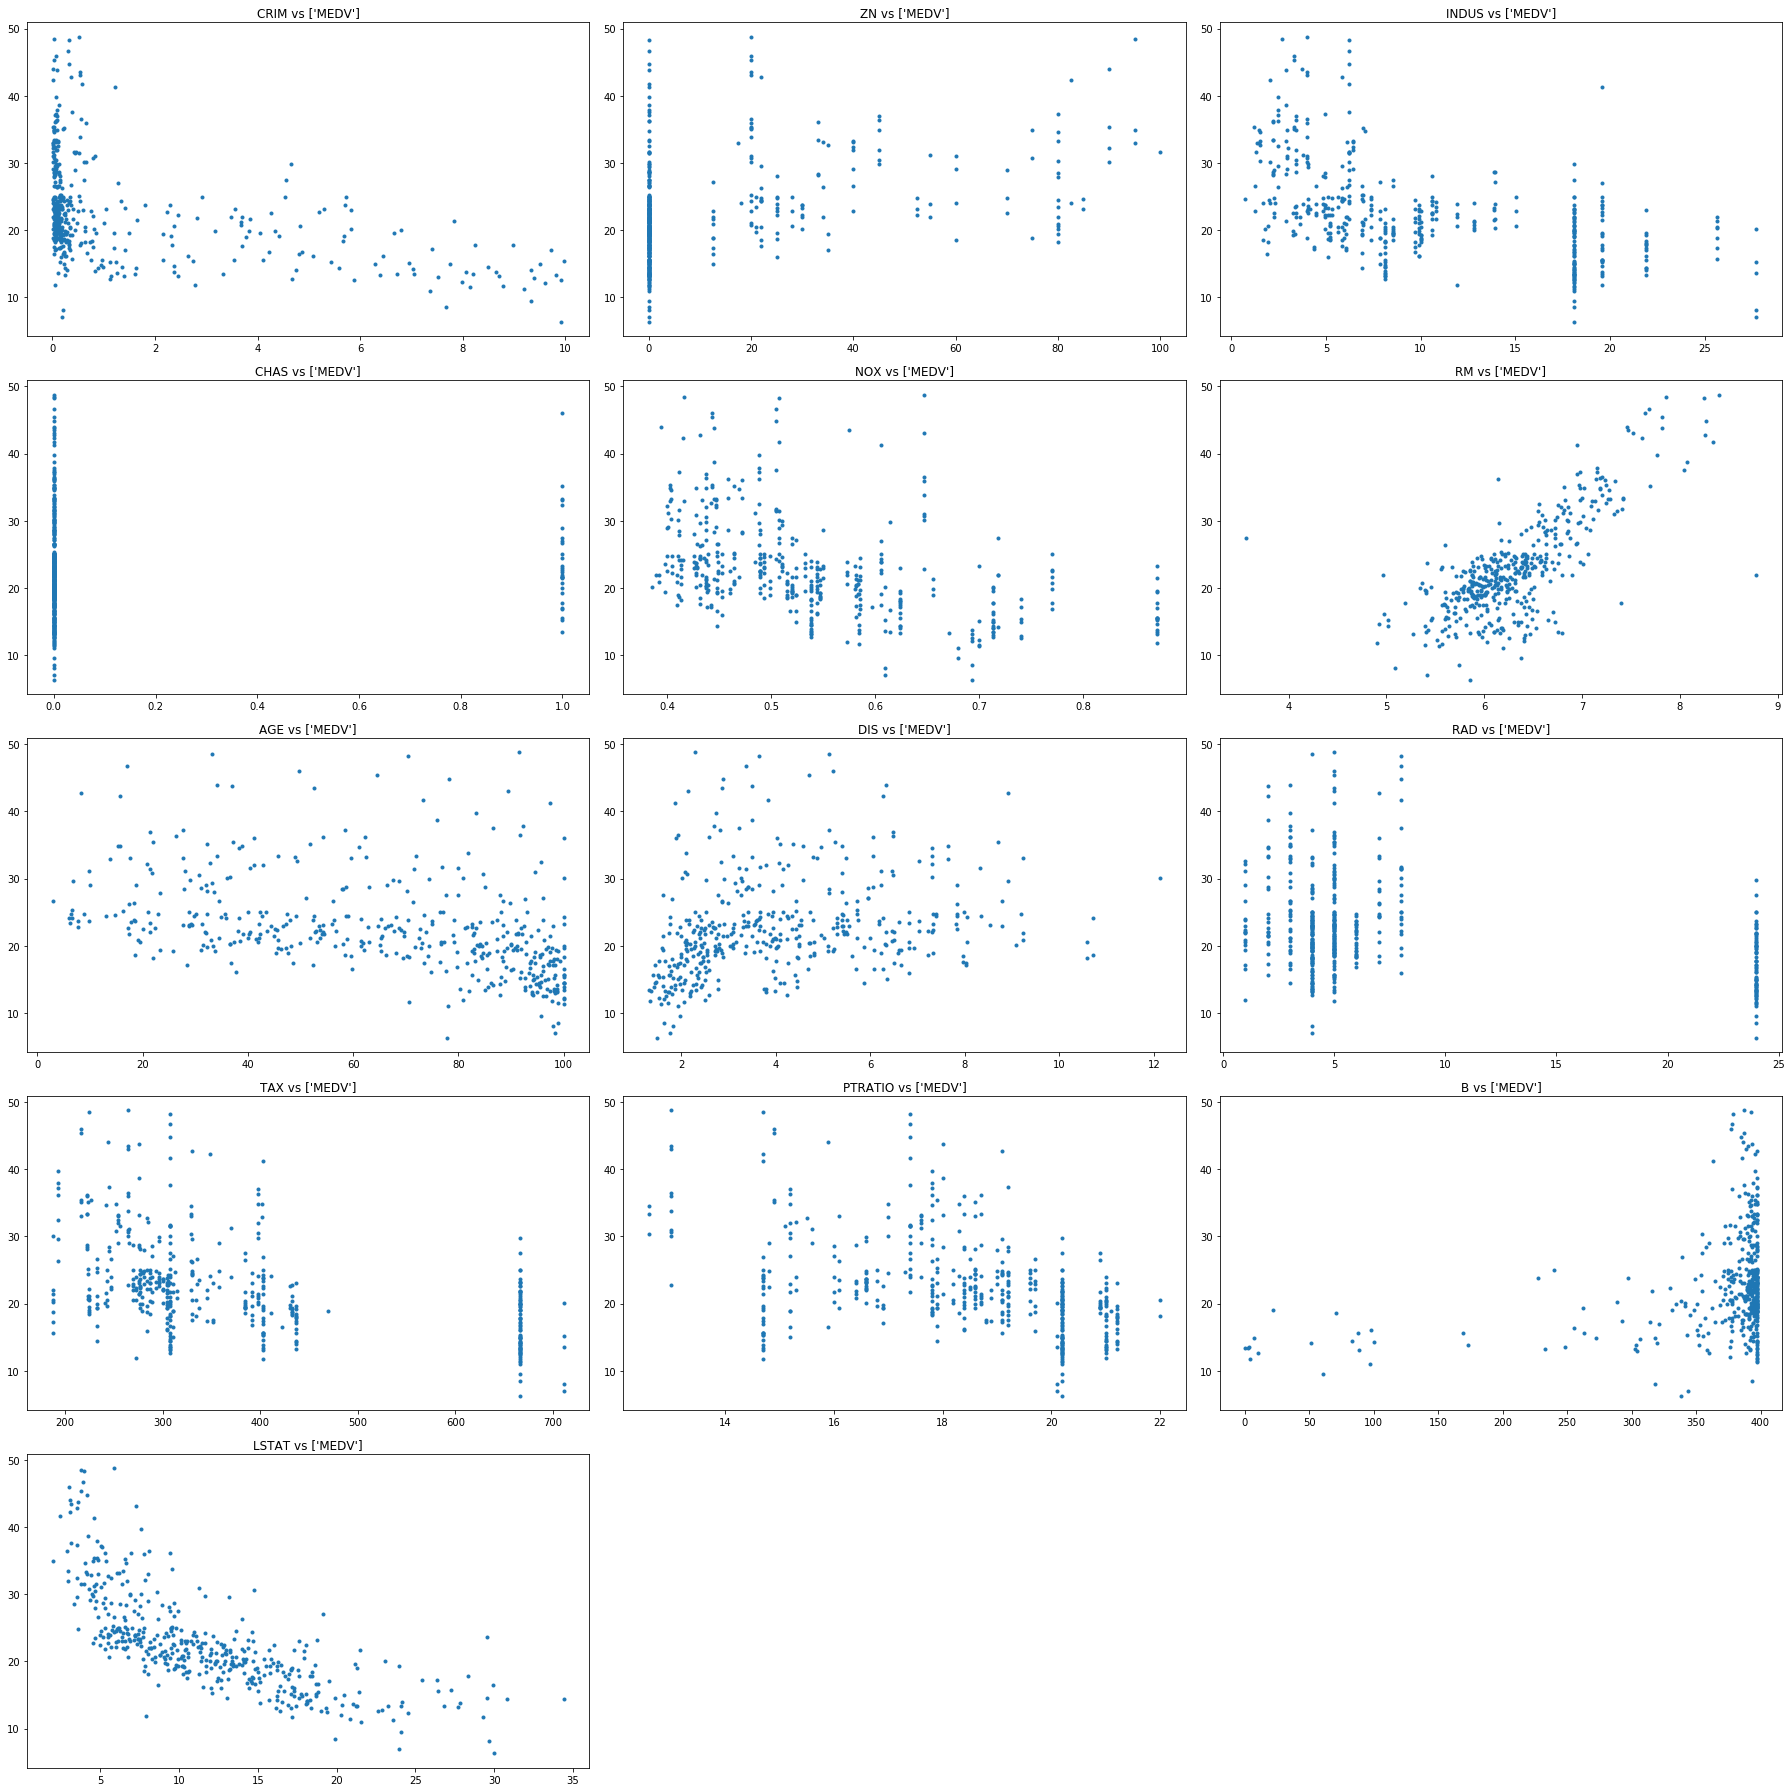

In [7]:
plot_dataset(input_dataset,response_column,feature_columns)

In [8]:
def plot_heatmap(input_dataset,response_column,feature_columns):
    sns.set(font_scale=1.5)
    cm=input_dataset.corr('pearson')
    f, ax = plt.subplots(figsize=(15,12))
    hm = sns.heatmap(cm,cbar=True,annot=True,square=True,annot_kws={'size': 15},
                     yticklabels=feature_columns+response_column,xticklabels=feature_columns+response_column)
    plt.show()
    
    
    


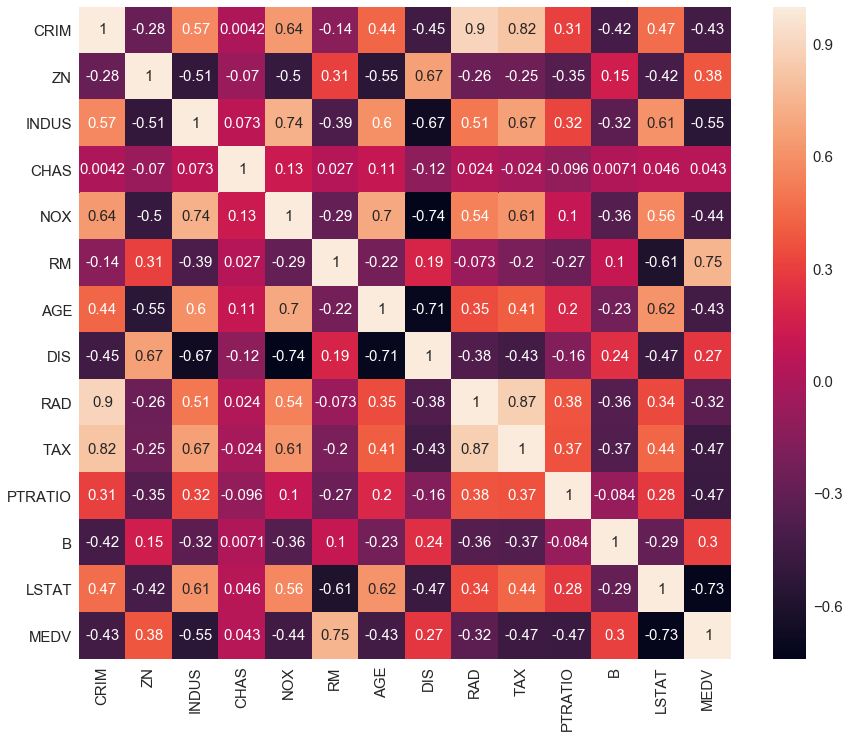

In [9]:
plot_heatmap(input_dataset,response_column,feature_columns)

In [10]:
from sklearn.model_selection import train_test_split
X=input_dataset[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT',]]
y=input_dataset[response_column].values
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=4)

std_X = StandardScaler().fit(X_train)
std_y = StandardScaler().fit(y_train)

scaler_X = std_X.fit_transform(X_train)
scaler_y = std_y.fit_transform(y_train.reshape(-1,1))
scaler_X_test = std_X.transform(X_test)
scaler_y_test = std_y.transform(y_test.reshape(-1,1))

In [11]:
from sklearn.model_selection import *
def train_and_evaluate(model, X_train, y_train):
    model.fit(X_train, y_train)
    print ("Coefficient of determination on training set:",model.score(X_train, y_train))
    # create a k-fold cross validation iterator of k=5 folds
    cv = KFold(n_splits= 5,shuffle=True, random_state=33)
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    print(scores)
    print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))
    

In [12]:
from sklearn import linear_model
clf_sgd = linear_model.SGDRegressor(loss='squared_loss',penalty=None,  random_state=42)
train_and_evaluate(clf_sgd,scaler_X,scaler_y.ravel())

Coefficient of determination on training set: 0.790474917936
[ 0.57888823  0.76708593  0.83250875  0.65063623  0.80960117]
Average coefficient of determination using 5-fold crossvalidation: 0.727744063917


In [13]:
# using SVM
from sklearn import svm
clf_svr = svm.SVR(kernel='linear')
train_and_evaluate(clf_svr,scaler_X,scaler_y.ravel())

Coefficient of determination on training set: 0.79772839219
[ 0.58765741  0.79766958  0.83487337  0.65387126  0.82265858]
Average coefficient of determination using 5-fold crossvalidation: 0.739346040612


In [14]:
# using polynomial
clf_svr_poly = svm.SVR(kernel='poly')
train_and_evaluate(clf_svr_poly,scaler_X,scaler_y.ravel())

Coefficient of determination on training set: 0.856434696865
[ 0.4925398   0.49946163  0.78084675 -0.69482558  0.69845853]
Average coefficient of determination using 5-fold crossvalidation: 0.355296226608


In [15]:
#Radial Basis Function (RBF) 
clf_svr_rbf = svm.SVR(kernel='rbf')
train_and_evaluate(clf_svr_rbf, scaler_X,scaler_y.ravel())

Coefficient of determination on training set: 0.914062873294
[ 0.84821873  0.81061766  0.9106246   0.85441853  0.84193693]
Average coefficient of determination using 5-fold crossvalidation: 0.853163289333


In [16]:
#ransac
from sklearn.linear_model import RANSACRegressor
from sklearn import linear_model
ransac = RANSACRegressor(linear_model.LinearRegression(),max_trials=100,min_samples=50,
                         loss='absolute_loss',residual_threshold=5.0, random_state=0)
train_and_evaluate(ransac, scaler_X,scaler_y.ravel())

Coefficient of determination on training set: 0.8077227544
[ 0.58486446  0.81257615  0.81837594  0.6395707   0.82675909]
Average coefficient of determination using 5-fold crossvalidation: 0.73642926759


In [17]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: -0.278
Intercept: 0.000


In [18]:
scale_features =pd.DataFrame(scaler_X,columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT',])
scale_response=pd.DataFrame(scaler_y,columns=['MEDV'])

all_columns =scale_features +scale_response
 

In [19]:
from sklearn import ensemble
clf_et=ensemble.ExtraTreesRegressor(n_estimators=10, random_state=42)
train_and_evaluate(clf_et, scaler_X,scaler_y.ravel())

Coefficient of determination on training set: 1.0
[ 0.84477439  0.81719616  0.9194142   0.68727803  0.86604004]
Average coefficient of determination using 5-fold crossvalidation: 0.826940564636


In [20]:
 clf_et.feature_importances_

array([ 0.05222648,  0.0461198 ,  0.09992498,  0.00310354,  0.0484221 ,
        0.3271683 ,  0.02723512,  0.01813986,  0.00779365,  0.03692623,
        0.04161368,  0.01601911,  0.27530715])

In [21]:
feature_imp=pd.DataFrame( clf_et.feature_importances_.reshape(1,13),columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'])
print(feature_imp)

       CRIM       ZN     INDUS      CHAS       NOX        RM       AGE  \
0  0.052226  0.04612  0.099925  0.003104  0.048422  0.327168  0.027235   

       DIS       RAD       TAX   PTRATIO         B     LSTAT  
0  0.01814  0.007794  0.036926  0.041614  0.016019  0.275307  


In [22]:
from sklearn import metrics
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)),"\n" )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred),"\n")
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),"\n")
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)),"\n")
    return y_pred

In [23]:
y_train_pred =measure_performance(scaler_X, scaler_y, clf_et,
                    show_accuracy=False, show_classification_report=False,
                    show_confusion_matrix=False, show_r2_score=True)

Coefficient of determination:1.000 



In [24]:
y_test_pred =measure_performance(scaler_X_test, scaler_y_test, clf_et,
                    show_accuracy=False, show_classification_report=False,
                    show_confusion_matrix=False, show_r2_score=True)

Coefficient of determination:0.841 



(305, 1)


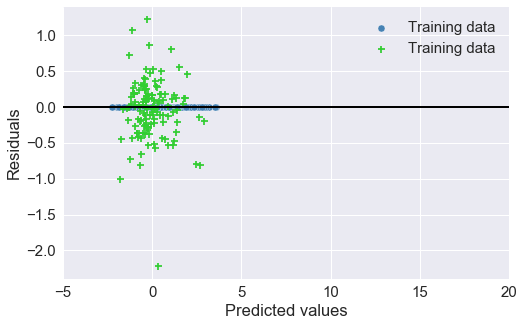

In [25]:
row,col=scaler_y.shape
y_train_pred =y_train_pred.reshape(row,col)
print(y_train_pred.shape)

row,col=scaler_y_test.shape
y_test_pred =y_test_pred.reshape(row,col)
fig = plt.figure(figsize=(8,5))
plt.scatter(y_train_pred,  y_train_pred - scaler_y,c='steelblue', marker='o', edgecolor='white',label='Training data')

plt.scatter(y_test_pred,  y_test_pred - scaler_y_test,c='limegreen', marker='+', edgecolor='white',label='Training data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-5, 20])
plt.show()